# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
## If you are using the data by mounting the google drive, use the following :
#from google.colab import drive
#drive.mount('/content/drive/')

In [22]:
import numpy as np
import os
from scipy.misc import imread, imresize
#from skimage.transform import resize
#from skimage.io import imread
import datetime
import os

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

We set the random seed so that the results don't vary drastically.

In [12]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [13]:
#train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
#val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
#base_path='/content/drive/My Drive/app/Gesture-Assignment/'
base_path='/datasets/'
train_doc = np.random.permutation(open(base_path+'Project_data/train.csv').readlines())
val_doc = np.random.permutation(open(base_path+'Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,13,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    image = resize(image,(100,100)).astype(np.float32)

                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            batch_data = np.zeros((batch_size,13,100,100,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image,(100,100)).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield does

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = base_path+'Project_data/train' #'/notebooks/storage/Final_data/Collated_training/train'
val_path = base_path+'Project_data/val' #'/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## First Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:


#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(13,100,100,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

2024-04-30 14:34:02.119459: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-04-30 14:34:02.119522: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22849 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:40:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [7]:
optimiser = 'sgd' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 100, 100, 32)  2624      
                                                                 
 activation (Activation)     (None, 13, 100, 100, 32)  0         
                                                                 
 batch_normalization (BatchN  (None, 13, 100, 100, 32)  128      
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 50, 50, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 50, 50, 64)     16448     
                                                                 
 activation_1 (Activation)   (None, 6, 50, 50, 64)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [6]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [9]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print(validation_steps)
print(steps_per_epoch)

4
21


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [35]:
import matplotlib.pyplot as plt
def plot_accur_graph(history,num_epochs1):
  plt.figure(figsize = (10,10))

  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(num_epochs1)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()


In [12]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_209/2585147562.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 32
Epoch 1/20


2024-04-30 14:34:48.354794: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.7358 - categorical_accuracy: 0.3661Source path =  /datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2024-04-3014_33_56.570157/model-00001-1.73582-0.36607-1.63369-0.21875.h5
21/21 [==============================] - 128s 6s/step - loss: 1.7358 - categorical_accuracy: 0.3661 - val_loss: 1.6337 - val_categorical_accuracy: 0.2188 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.3211 - categorical_accuracy: 0.5149
Epoch 00002: saving model to model_init_2024-04-3014_33_56.570157/model-00002-1.32110-0.51488-1.86923-0.24219.h5
21/21 [==============================] - 100s 5s/step - loss: 1.3211 - categorical_accuracy: 0.5149 - val_loss: 1.8692 - val_categorical_accuracy: 0.2422 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.1000 - categorical_accuracy: 0.5923
Epoch 00003: saving model to model_init_2024-04-3014_33_56.570157/model-0

<Figure size 720x720 with 0 Axes>

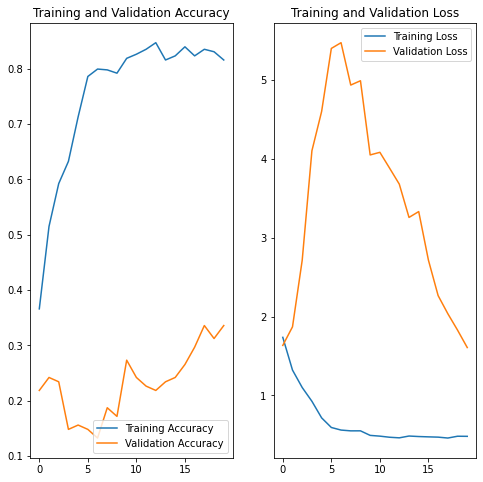

In [20]:
plot_accur_graph(history,num_epochs)

# Model 2 
will increase the batch size,number of epochs and will change the optimizer sgd to adam with learning rate

In [9]:
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(13,100,100,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

2024-05-01 06:29:30.632863: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-05-01 06:29:30.632922: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


In [10]:
import tensorflow as tf
batch_size1 = 64
train_generator = generator(train_path, train_doc, batch_size1)
val_generator = generator(val_path, val_doc, batch_size1)

model_name = 'model2_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 100, 100, 32)  2624      
                                                                 
 activation (Activation)     (None, 13, 100, 100, 32)  0         
                                                                 
 batch_normalization (BatchN  (None, 13, 100, 100, 32)  128      
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 50, 50, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 50, 50, 64)     16448     
                                                                 
 activation_1 (Activation)   (None, 6, 50, 50, 64)     0

In [11]:
m2_num_epochs=30
history2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=m2_num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_645/2738974114.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=m2_num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 64
Epoch 1/30


2024-05-01 06:29:50.465858: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 2.3558 - categorical_accuracy: 0.2262Source path =  /datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model2_init_2024-05-0106_29_06.953356/model-00001-2.35583-0.22619-1.64281-0.17969.h5
21/21 [==============================] - 139s 7s/step - loss: 2.3558 - categorical_accuracy: 0.2262 - val_loss: 1.6428 - val_categorical_accuracy: 0.1797 - lr: 1.0000e-05
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.8925 - categorical_accuracy: 0.3438
Epoch 00002: saving model to model2_init_2024-05-0106_29_06.953356/model-00002-1.89254-0.34375-1.71713-0.22266.h5
21/21 [==============================] - 137s 7s/step - loss: 1.8925 - categorical_accuracy: 0.3438 - val_loss: 1.7171 - val_categorical_accuracy: 0.2227 - lr: 1.0000e-05
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.6491 - categorical_accuracy: 0.3869
Epoch 00003: saving model to model2_init_2024-05-0106_29_06.953

<Figure size 720x720 with 0 Axes>

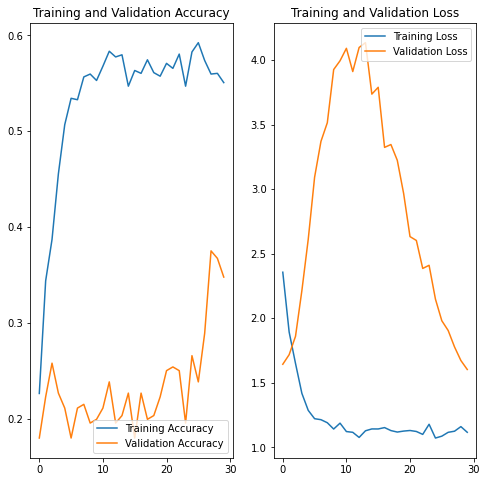

In [12]:
plot_accur_graph(history2,m2_num_epochs)

# Model 3
with LSTM

In [14]:
from keras.layers.recurrent import LSTM


model3 = Sequential()
model3.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(13,100,100,3)))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(64, (2, 2, 2), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(128, (2, 2, 2), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(TimeDistributed(Flatten()))
model3.add(LSTM(128))
model3.add(Dropout(0.5))

model3.add(Dense(64,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Dense(5,activation='softmax'))

2024-05-01 04:56:54.595979: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-05-01 04:56:54.596054: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


In [15]:
batch_size = 32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model3_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [16]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 100, 100, 32)  2624      
                                                                 
 activation (Activation)     (None, 13, 100, 100, 32)  0         
                                                                 
 batch_normalization (BatchN  (None, 13, 100, 100, 32)  128      
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 50, 50, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 50, 50, 64)     16448     
                                                                 
 activation_1 (Activation)   (None, 6, 50, 50, 64)     0

In [17]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [18]:
m3_num_epochs=20
history3 = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=m3_num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_239/3700006923.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=m3_num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 32
Epoch 1/20


2024-05-01 04:57:27.006446: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 2.4141 - categorical_accuracy: 0.1979Source path =  /datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model3_init_2024-05-0104_56_20.859183/model-00001-2.41414-0.19792-1.60803-0.22656.h5
21/21 [==============================] - 100s 5s/step - loss: 2.4141 - categorical_accuracy: 0.1979 - val_loss: 1.6080 - val_categorical_accuracy: 0.2266 - lr: 1.0000e-05
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.9655 - categorical_accuracy: 0.2708
Epoch 00002: saving model to model3_init_2024-05-0104_56_20.859183/model-00002-1.96551-0.27083-1.60895-0.24219.h5
21/21 [==============================] - 70s 4s/step - loss: 1.9655 - categorical_accuracy: 0.2708 - val_loss: 1.6089 - val_categorical_accuracy: 0.2422 - lr: 1.0000e-05
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.7358 - categorical_accuracy: 0.3274
Epoch 00003: saving model to model3_init_2024-05-0104_56_20.8591

<Figure size 720x720 with 0 Axes>

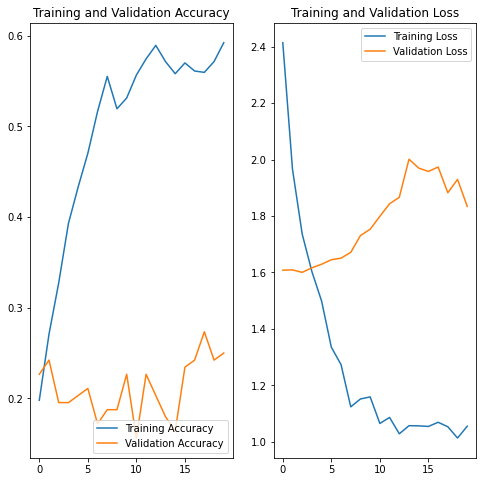

In [19]:
plot_accur_graph(history3,m3_num_epochs)

# Model4

TimeDistributed Conv2D + GRU

In [8]:
import cv2

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,20,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    image = resize(image,(120,120)).astype(np.float32)
                    #image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)    
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            batch_data = np.zeros((batch_size,20,120,120,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield does

In [9]:
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D

model4 = Sequential()
model4.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(20,120,120,3)))
model4.add(TimeDistributed(MaxPooling2D((2,2))))
model4.add(BatchNormalization())

model4.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model4.add(TimeDistributed(MaxPooling2D((2,2))))
model4.add(BatchNormalization())

model4.add(TimeDistributed(Conv2D(128, (3,3), activation='relu')))
model4.add(TimeDistributed(MaxPooling2D((2,2))))
model4.add(BatchNormalization())

model4.add(TimeDistributed(GlobalAveragePooling2D()))
model4.add(TimeDistributed(Dense(64, activation='relu')))
model4.add(BatchNormalization())

model4.add(GRU(128))
model4.add(BatchNormalization())
model4.add(Dense(5, activation='softmax'))

2024-05-01 08:02:07.906378: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-05-01 08:02:07.906442: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

batch_size = 32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model4_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [11]:
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 118, 118, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 20, 59, 59, 32)   128       
 ormalization)                                                   
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 57, 57, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 28, 28, 64)   0

In [12]:
m4_num_epochs=30
history4 = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=m4_num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_206/774039227.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history4 = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=m4_num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 32
Epoch 1/30


2024-05-01 08:02:26.372789: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.6404 - categorical_accuracy: 0.2054Source path =  /datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model4_init_2024-05-0108_01_40.751964/model-00001-1.64035-0.20536-1.62503-0.21094.h5
21/21 [==============================] - 84s 4s/step - loss: 1.6404 - categorical_accuracy: 0.2054 - val_loss: 1.6250 - val_categorical_accuracy: 0.2109 - lr: 1.0000e-05
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5195 - categorical_accuracy: 0.3095
Epoch 00002: saving model to model4_init_2024-05-0108_01_40.751964/model-00002-1.51945-0.30952-1.67026-0.17969.h5
21/21 [==============================] - 79s 4s/step - loss: 1.5195 - categorical_accuracy: 0.3095 - val_loss: 1.6703 - val_categorical_accuracy: 0.1797 - lr: 1.0000e-05
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.4057 - categorical_accuracy: 0.3943
Epoch 00003: saving model to model4_init_2024-05-0108_01_40.75196

In [52]:
plot_accur_graph(history4,m4_num_epochs)

NameError: name 'plot_accur_graph' is not defined

# Model5

In [47]:
import cv2

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,20,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(120,120,3))
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                        
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            batch_data = np.zeros((batch_size,20,120,120,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(120,120,3))
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield does

In [48]:
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D

model5 = Sequential()
model5.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(20,120,120,3)))
model5.add(TimeDistributed(MaxPooling2D((2,2))))
model5.add(BatchNormalization())

model5.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model5.add(TimeDistributed(MaxPooling2D((2,2))))
model5.add(BatchNormalization())

model5.add(TimeDistributed(Conv2D(128, (3,3), activation='relu')))
model5.add(TimeDistributed(MaxPooling2D((2,2))))
model5.add(BatchNormalization())

model5.add(TimeDistributed(GlobalAveragePooling2D()))
model5.add(TimeDistributed(Dense(64, activation='relu')))
model5.add(BatchNormalization())

model5.add(GRU(128))
model5.add(BatchNormalization())
model5.add(Dense(5, activation='softmax'))

In [49]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

batch_size = 32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model5_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [50]:
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_49 (TimeDi  (None, 20, 118, 118, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 20, 59, 59, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_30 (Bat  (None, 20, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_51 (TimeDi  (None, 20, 57, 57, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 20, 28, 28, 64)  

In [51]:
m5_num_epochs=25
history5 = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=m5_num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 32
Epoch 1/25


2024-05-01 10:30:38.853145: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.4547 - categorical_accuracy: 0.3795Source path =  /datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model5_init_2024-05-0110_14_08.858852/model-00001-1.45475-0.37946-1.60266-0.21875.h5
21/21 [==============================] - 137s 7s/step - loss: 1.4547 - categorical_accuracy: 0.3795 - val_loss: 1.6027 - val_categorical_accuracy: 0.2188 - lr: 1.0000e-05
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.3582 - categorical_accuracy: 0.4390
Epoch 00002: saving model to model5_init_2024-05-0110_14_08.858852/model-00002-1.35823-0.43899-1.61162-0.27344.h5
21/21 [==============================] - 141s 7s/step - loss: 1.3582 - categorical_accuracy: 0.4390 - val_loss: 1.6116 - val_categorical_accuracy: 0.2734 - lr: 1.0000e-05
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 1.2877 - categorical_accuracy: 0.4792
Epoch 00003: saving model to model5_init_2024-05-0110_14_08.858

<Figure size 720x720 with 0 Axes>

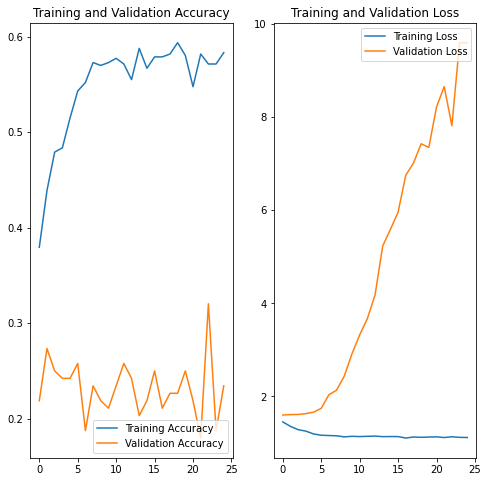

In [54]:
plot_accur_graph(history5,m5_num_epochs)

# Model 6 - using VGG

In [23]:
from keras.models import  Model
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import regularizers

In [24]:
batch_size = 32 
HEIGHT_DIMENSION=120 
WIDTH_DIMENSION=120
INPUT_SIZE_IN_BATCH=20
INPUT_PER_FOLDER=30
y=HEIGHT_DIMENSION
z=WIDTH_DIMENSION

In [3]:
!pip install scipy==1.1.0

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [25]:
from scipy.misc import imread, imresize
def cropAndResize(imag,HEIGHT_DIMENSION,WIDTH_DIMENSION):
    if abs(imag.shape[0]-imag.shape[1])%2==0 and imag.shape[0]!=imag.shape[1]:
        dimension_diff=abs(imag.shape[0]-imag.shape[1])
        cropping_ratio=dimension_diff//2
        if imag.shape[0]>imag.shape[1]:
            imag=imag[cropping_ratio:imag.shape[0]-cropping_ratio,:,:]
        elif imag.shape[0]<imag.shape[1]:
            imag=imag[:,cropping_ratio:imag.shape[1]-cropping_ratio,:]
                    
    
    if imag.shape[0]>HEIGHT_DIMENSION or imag.shape[1]>WIDTH_DIMENSION:
        imag=imresize(imag,size=(HEIGHT_DIMENSION,WIDTH_DIMENSION),
                      interp='bilinear',mode='RGB')
        
    return imag

In [26]:
def normalize(imag):    
    return (imag[:,:,0]-imag[:,:,0].mean())/imag[:,:,0].std(), (imag[:,:,1]-imag[:,:,1].mean())/imag[:,:,1].std(), (imag[:,:,2]-imag[:,:,2].mean())/imag[:,:,2].std()

In [27]:
def generator(source_path, folder_list, batch_size):
    print("Inside generator")
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    NUM_FOLDERS=len(folder_list)
    num_batches = NUM_FOLDERS//batch_size
    remaining_batch_size=NUM_FOLDERS%batch_size
    while True:        
        t = np.random.permutation(folder_list)                
        for batch in range(num_batches): # we iteratINPUT_SIZE_IN_BATCHe,INPUT_SIZE_IN_BATCH over the number of batches
            batch_data = np.zeros((batch_size,INPUT_SIZE_IN_BATCH,y,z,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            mandatory = [0,1,28,29]
            random_list_1 = rn.sample(range(2,28),INPUT_SIZE_IN_BATCH - 4)
            random_list_1.extend(mandatory)
            random_list_1.sort()
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(random_list_1): #  Iterate iver the frames/images of a folder to read them in
                    imag = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    imag = cropAndResize(imag,HEIGHT_DIMENSION,WIDTH_DIMENSION)
                    #NORMALIZING   
                    batch_data[folder,idx,:,:,0], batch_data[folder,idx,:,:,1], batch_data[folder,idx,:,:,2] = normalize(imag)                            
                                
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1                
                               
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        for batch in range(num_batches,num_batches+1): # we iterate over the number of batches
            rem_batch_data = np.zeros((remaining_batch_size*2,INPUT_SIZE_IN_BATCH,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            rem_batch_labels = np.zeros((remaining_batch_size*2,5)) # batch_labels is the one hot representation of the output
            mandatory = [0,1,28,29]
            random_list_1 = rn.sample(range(2,28),INPUT_SIZE_IN_BATCH - 4)
            random_list_1.extend(mandatory)
            random_list_1.sort()
            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(random_list_1): #  Iterate iver the frames/images of a folder to read them in
                    imag = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    imag = cropAndResize(imag,HEIGHT_DIMENSION,WIDTH_DIMENSION)
                    #NORMALIZING   
                    rem_batch_data[folder,idx,:,:,0], rem_batch_data[folder,idx,:,:,1], rem_batch_data[folder,idx,:,:,2] = normalize(imag)
                                
                rem_batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
        yield rem_batch_data, rem_batch_labels

In [19]:
import datetime
curr_dt_time = datetime.datetime.now()
train_path = base_path+'Project_data/train' #'/notebooks/storage/Final_data/Collated_training/train'
val_path = base_path+'Project_data/val' #'/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [28]:
from keras.layers import CuDNNLSTM,Flatten
base_model = VGG16(include_top=False, weights='imagenet',input_shape=(WIDTH_DIMENSION, HEIGHT_DIMENSION,3))
x = base_model.output
x = Flatten()(x)

for layer in base_model.layers:
    layer.trainable = False

model = Model(inputs=base_model.input, outputs=x)

fin_model = Sequential()
fin_model.add(TimeDistributed(model, input_shape=(INPUT_SIZE_IN_BATCH,WIDTH_DIMENSION,HEIGHT_DIMENSION,3)))
fin_model.add(CuDNNLSTM(64,return_sequences=False))
fin_model.add(Dropout(0.5))
fin_model.add(Dense(5, activation='softmax'))

In [29]:
fin_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (fin_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 4608)         14714688  
 ibuted)                                                         
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 64)                1196544   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 15,911,557
Trainable params: 1,196,869
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [30]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [31]:
model_name = 'model6_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'hgr_sgd.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.000001) # write the REducelronplateau code here
ES = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
callbacks_list = [checkpoint,LR,ES]

In [32]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [33]:
history6=fin_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_4462/558355507.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history6=fin_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1,
/tmp/ipykernel_4462/286454884.py:19: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  imag = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Inside generator
Source path =  /datasets/Project_data/train ; batch size = 32


/tmp/ipykernel_4462/562910763.py:13: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  imag=imresize(imag,size=(HEIGHT_DIMENSION,WIDTH_DIMENSION),


Epoch 1/50


2024-05-01 11:43:32.751736: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


19/21 [==========================>...] - ETA: 4s - loss: 1.8002 - categorical_accuracy: 0.1661

/tmp/ipykernel_4462/286454884.py:38: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  imag = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


21/21 [==============================] - ETA: 0s - loss: 1.7413 - categorical_accuracy: 0.1603Inside generator
Source path =  /datasets/Project_data/val ; batch size = 32

Epoch 00001: val_categorical_accuracy improved from -inf to 0.17308, saving model to model6_init_2024-05-0111_41_55.795012/hgr_sgd.h5
21/21 [==============================] - 75s 3s/step - loss: 1.7413 - categorical_accuracy: 0.1603 - val_loss: 1.5927 - val_categorical_accuracy: 0.1731 - lr: 1.0000e-05
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.6538 - categorical_accuracy: 0.2318
Epoch 00002: val_categorical_accuracy improved from 0.17308 to 0.23077, saving model to model6_init_2024-05-0111_41_55.795012/hgr_sgd.h5
21/21 [==============================] - 57s 3s/step - loss: 1.6538 - categorical_accuracy: 0.2318 - val_loss: 1.5518 - val_categorical_accuracy: 0.2308 - lr: 1.0000e-05
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.6079 - categorical_accuracy: 0.2318
Epoch

<Figure size 720x720 with 0 Axes>

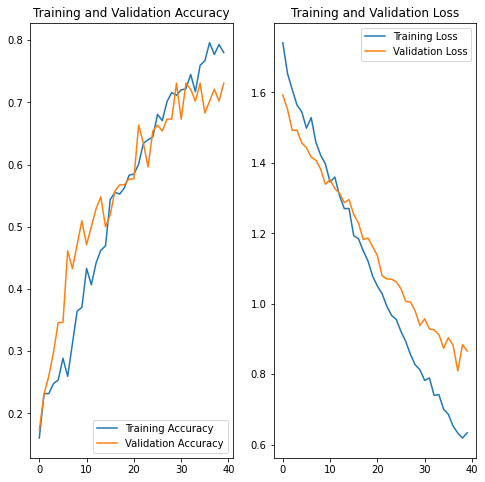

In [37]:
plot_accur_graph(history6,40)